In [115]:
import numpy as np
import pandas as pd
import random
import time
from multiprocessing import Pool

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import xgboost as xgb

# For data visualization
import matplotlib.pyplot as plt
# from pandas.tools.plotting import autocorrelation_plot
from bokeh.io import output_notebook, show
from bokeh.models import Title
from bokeh.plotting import figure, output_file, show

import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta, date
from tqdm import tqdm            #for .py version
# from tqdm import tqdm_notebook as tqdm     # for .ipynb version

pd.options.mode.chained_assignment = None  # default='warn'

In [116]:
# The dict 'params' consists of all the parameters used in the simulation software for ease of alteration
params = {
#         Set the regression model related parameters
          'train_start_dt':'2013-01',
          'train_stop_dt':'2013-12',
          'y_variable': 'trial_d',
          'X_variables':['trial_n', 'low', 'normal', 'high', 'WIND_DIRECTION',
                         'WIND_SPEED', 'VISIBILITY', 'MSL_PRESSURE',
                         'AIR_TEMPERATURE', 'DEWPOINT', 'WETB_TEMP', 
                         'STN_PRES', 'WMO_HR_SUN_DUR', 'hour', 'day'],
    
#         Set XGBoost regression parameters (for consumption model)
          'n_estimators': 2000,
          'early_stopping_rounds': 50,  #stop if 50 consequent rounds without decrease of error
          'verbose': False,             # Change verbose to True if you want to see it train
          'nthread': 4,
    
#         Set simulator parameters to default values
          'season': 3,
          'day_of_week': 3,
          'special_event': 0,
          'tariff_policy':[],
    
#         Set Occupant behaviour dynamics
          'active_users': 0.1,#.5,     # Set the % of users who are willing to engage in the experiments
          'avail_users': 0.1,#.5,       # Set the % of users who will be available to participate in specific experiment
          'user_latency': 0,         # Set the values which correspond to real life participation delay for users 
          'frac_users_exp':1,      # Fraction of users selected for a particular trial
          
#         Set parameters for active learning
          'total_iterations':5,
          'total_experiments':500,#100, #Total number of experiments allowed per trial
          'init_samples': 30,#50,      # Set the initial random samples to be chosen
          'test_size':.3,           # Set test data size for splitting data in train-test
          'X_var_activeL':['dow', 
                           'season', 
                           'hod', 
                           'AIR_TEMPERATURE', 
                           'DEWPOINT', 
                           'MSL_PRESSURE', 
                           'STN_PRES',
                           'VISIBILITY', 
                           'WETB_TEMP',
                           'WIND_DIRECTION',
                           'WIND_SPEED',
                           'WMO_HR_SUN_DUR',
                           'hod', 
                           'month',
                           'tariff'],
          'X_var_supervised':['dow', 
                           'season', 
                           'hod', 
                           'AIR_TEMPERATURE', 
                           'DEWPOINT', 
                           'MSL_PRESSURE', 
                           'STN_PRES',
                           'VISIBILITY', 
                           'WETB_TEMP',
                           'WIND_DIRECTION',
                           'WIND_SPEED',
                           'WMO_HR_SUN_DUR',
                           'hod', 
                           'month',
                           'tariff_original'],
    
          'y_var_activeL':['response', 'expected']
         }

## Generator
This class creates a new data point on request. The new datapoint can be constrained to some calendar parameters like day-of-week and season-of-year. The following cell randomly selects the date index which follows the input constraints and generates a 'new' datapoint by aggregating the data of multiple LCL energy users.

Also the tariff policy and user response for that particular day is decided by modelling stochastic behaviour of users. Therefore, each user's response is calculated individually by considering user latency into account.

In [117]:
class Generator(object):
    
    
    def __init__(self, df):
        self.df = df
        self.spring = [3, 4, 5]
        self.summer = [6, 7, 8]
        self.autumn = [9, 10, 11]
        self.winter = [1, 2, 12]


     
        
    def next_sample(self):
    
#         Sample a random day timestamp
        shortlist = self.df.sample(axis = 0).index
        random_index = random.choice(shortlist)
#         print(random_index)

        self.timestamp = str(random_index.year)+"-"+str(random_index.month)+"-"+str(random_index.day)
        df_sample = self.df.loc[self.timestamp,:]
        
        df_sample = df_sample.loc[~df_sample.index.duplicated(keep='first')]
#         print("next_sample size:", df_sample.shape)
        return df_sample
        
        
    
   

## Active Learner
The following cell simulates the real-world scenario to mimic the practical trials. The only difference is that the dates are randomly selected rather than sequentially moving in time. 

The following algorithm gets the features set for the next datapoint and based on the knowledge of the historical feature subspace, it then takes a decision about the 'need' of an labelling experiment. That is, if the situation is rare in the historical data, the learner will give it more importance as it contains more information (Information theory says that the probability of occurance of a symbol is inversely proportional to the infomation contained in it)

In [118]:
class activeLearner(object):
    
    def __init__(self, params):
        self.params = params
        self.y_pred_AL = pd.DataFrame()
        self.y_test_AL = pd.DataFrame()
        self.y_pred_SUP = pd.DataFrame()
        self.y_test_SUP = pd.DataFrame()
        self.counter = 0
        self.iter = 1
        
        
        
            
    def sample_stream(self):
        
        #Randomly select next data point
        response = gen.next_sample()

        df = response.copy()
#         print(df.shape)
#         print(df.index[0])
#         print("sample_stream ", df)

        return df
    
    
    
    
    def get_random_samples(self):
        
        response = gen.next_sample()
        self.df = response.copy()
            
#        Create n number of datapoints from simulator (n=self.params["init_samples"])
        list_ = [i for i in range(self.params["init_samples"])]

        for i in tqdm(list_):
            
            response = gen.next_sample()           
            self.df = pd.concat([self.df, response], axis=0, sort=True)
            
            
            
    def split_data(self, df):
        
        X_train = df[self.params['X_var_activeL']]
        y_train = df[self.params['y_var_activeL']]
#         print(y_train)
        return X_train, y_train
        
        
        
    def train_model(self, X_train, y_train):
        self.regres = 0
        self.regres = RandomForestRegressor(n_estimators=10)
        self.regres.fit(X_train, y_train)
        
        
    def predict(self, X_test, y_test):
        
#         self.y_pred.loc[:, exp_id] = 
        
        return self.regres.predict(X_test)
#         self.y_test.loc[:, exp_id] = y_test.values

        
        
        
        
    def get_pred_var(self, X_test):
        preds = np.stack([t.predict(X_test) for t in self.regres.estimators_])
        pred_var = np.mean(np.var(preds, axis=0))
#         err_mean = np.mean(np.mean(preds, axis=0)-y_test)
        return pred_var #, err_mean

        
    def get_error_measure(self, y_test, y_pred):
        mse = ((y_test - y_pred)**2).mean(axis=0)
        return mse
    
                     
    def get_experiment_id(self):
        self.exp_id = 0            #initialize
        
        exp_available = self.params["total_experiments"] - self.params["init_samples"]
        
        if self.counter > exp_available:
            self.counter=0
            self.iter = self.iter + 1
            
        exp_count = str(self.counter)
        iter_count = str(self.iter)
        self.exp_id = "iter" + iter_count + "_exp" + exp_count
        self.counter = self.counter + 1
       

        
# Run the active learning model for a given number of experiments

    def run(self):
        
        self.p_var = []
        self.e_mean = []
        i=0

        #         Get initial samples to train model
        self.get_random_samples()
                
        X_train, y_train= self.split_data(self.df)
        self.train_model(X_train, y_train['expected'])        
        
        list_ = [i for i in range(self.params["total_experiments"] - self.params["init_samples"])]
        for exp in tqdm(list_):
            
#             print('start')
            next_sample = self.sample_stream()
#             print('stop')
            X_test, y_test= self.split_data(next_sample)
#             print(y_test['response'])
            pred_var = self.get_pred_var(X_test)
            
            self.get_experiment_id()
            
                        
            ########################################################
#             Supervised Algorithm (All labels)
            ########################################################
            y_test_sup = y_test["response"]
            preds_sup = self.predict(X_test, y_test_sup)
            self.y_pred_SUP.loc[:, self.exp_id] = preds_sup
            self.y_test_SUP.loc[:, self.exp_id] = y_test_sup.values
            ########################################################
            
            
            
            #########################################################
#             Active Learning Block
            #########################################################
            if pred_var>0.00050:
                y = y_test["response"]
                preds = self.predict(X_test, y)
                i = i+1
                
            else:
                y = y_test["expected"]
                X_test["tariff"]=0
                next_sample['tariff']=0
                preds = self.predict(X_test, y)
            
            self.y_pred_AL.loc[:, self.exp_id] = preds
            self.y_test_AL.loc[:, self.exp_id] = y.values

            ########################################################
            

            
            
            
            self.p_var.append(pred_var)
            self.df = pd.concat([self.df, next_sample], axis=0, sort=True)
            X_train, y_train= self.split_data(self.df)
            self.train_model(X_train, y_train['response'])
            
        print("total label queries: ", i)
            
            

In [119]:
def import_data():
    try:
        print("Reading generated data...")
        df = pd.read_csv('~/Documents/work/Active-Learning-TUD-Thesis/mod_datasets/samples.csv', sep='\t', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
        df['tariff_original'] = df['tariff']
        
    except Exception as e: print(e)
        
    return df

In [120]:
def _init():
    df = import_data()
    
    try:
        gen = Generator(df)
        trials_ = activeLearner(params)
        
    except Exception as e: print(e)    
    
    return gen, trials_#, selectsample

In [129]:
def plot_bokeh(y1, y2, x, title, xlabel, ylabel):
    output_notebook()
    file_name = "../temp/" + title + ".html"
#     output_file(file_name) #Uncom`ment it to save the plot in html file


    p=figure(plot_width=800, plot_height=400, title = title, x_axis_label = xlabel, y_axis_label = ylabel,)
    p.line(x, y1, line_width=1, legend = "MSE for supervised learning", color='blue')
    p.line(x, y2, line_width=1, legend = "MSE for Active learning", color='orange')

    show(p)

In [122]:
if __name__ == '__main__':
#     # import data and declare classes
    gen, trials_= _init()
    df_AL = pd.DataFrame()
    df_SUP = pd.DataFrame()

#     # start the simulator and active learning by membership query synthesis
    for i in range(100):
        trials_.run()
        AL_error = trials_.y_pred_AL - trials_.y_test_AL
        AL_mean = AL_error.mean(axis=0).abs()
        df_AL.loc[:,i] = AL_mean

        SUP_error = trials_.y_pred_SUP - trials_.y_test_SUP
        SUP_mean = SUP_error.mean(axis=0).abs()
        df_SUP.loc[:,i] = SUP_mean

        
        
#     plot_bokeh(trials_.p_var, trials_.e_mean, "Relation between predication variance of trees and prediction error", "Prediction error", "Prediction variance")


#     plt.ylim(0, 0.002)
#     x = [abs(number) for number in trials_.e_mean] 
# #     print(x)
#     plt.scatter(x, trials_.p_var)
#     plt.title('Scatter plot of predication variance of trees and prediction error')
#     plt.xlabel('Prediction error')
#     plt.ylabel('Prediction variance')
#     plt.show()

#     list_ = [i for i in range(len(mse))]
#     d = {'0':mse}
    
#     for i in range(params["total_iterations"]):
#         print("Iteration", i+1) 
#         trials_.run()
    
    
    
    
    
#     title = "Mean Squared Error vs Number of samples"
#     xlabel = "Number of iterations"
#     ylabel = "MSE"
#     list_ = [i for i in range(params["total_experiments"])]
    
#     plot_bokeh(mse_total.mean(axis=1), list_, title, xlabel, ylabel)
    
    
    
    
    today = date.today()

    
    file_name = "../results/generated_data" + str(today) + ".csv"
    trials_.df.to_csv(file_name, sep='\t')
        
    file_name = "../results/AL_predictions" + str(today) + ".csv"
    trials_.y_pred_AL.to_csv(file_name, sep='\t')
    
    file_name = "../results/AL_actuals" + str(today) + ".csv"
    trials_.y_test_AL.to_csv(file_name, sep='\t')
    
    file_name = "../results/SUP_predictions" + str(today) + ".csv"
    trials_.y_pred_AL.to_csv(file_name, sep='\t')
    
    file_name = "../results/SUP_actuals" + str(today) + ".csv"
    trials_.y_test_AL.to_csv(file_name, sep='\t')
    
    file_name = "../results/feature_set" + str(today) + ".txt"
    with open(file_name, "w") as output:
        output.write(str(params["X_var_activeL"]))
    
    print("Data saved.")
#     print("summary:")

Reading generated data...


 43%|████▎     | 13/30 [00:00<00:00, 124.94it/s]

total label queries:  37


 47%|████▋     | 14/30 [00:00<00:00, 135.43it/s]

total label queries:  39


 47%|████▋     | 14/30 [00:00<00:00, 133.75it/s]

total label queries:  31


 47%|████▋     | 14/30 [00:00<00:00, 135.13it/s]

total label queries:  41


 47%|████▋     | 14/30 [00:00<00:00, 132.08it/s]

total label queries:  18


 33%|███▎      | 10/30 [00:00<00:00, 95.29it/s]

total label queries:  33


 43%|████▎     | 13/30 [00:00<00:00, 128.29it/s]

total label queries:  38


 47%|████▋     | 14/30 [00:00<00:00, 138.45it/s]

total label queries:  34


 47%|████▋     | 14/30 [00:00<00:00, 137.01it/s]

total label queries:  20


 47%|████▋     | 14/30 [00:00<00:00, 135.23it/s]

total label queries:  33


 47%|████▋     | 14/30 [00:00<00:00, 133.20it/s]

total label queries:  32


 47%|████▋     | 14/30 [00:00<00:00, 136.73it/s]

total label queries:  33


 47%|████▋     | 14/30 [00:00<00:00, 135.77it/s]

total label queries:  38


 47%|████▋     | 14/30 [00:00<00:00, 137.48it/s]

total label queries:  21


 47%|████▋     | 14/30 [00:00<00:00, 133.31it/s]

total label queries:  35


 47%|████▋     | 14/30 [00:00<00:00, 138.27it/s]

total label queries:  20


 50%|█████     | 15/30 [00:00<00:00, 142.69it/s]

total label queries:  33


 47%|████▋     | 14/30 [00:00<00:00, 136.47it/s]

total label queries:  18


 50%|█████     | 15/30 [00:00<00:00, 142.10it/s]

total label queries:  25


 47%|████▋     | 14/30 [00:00<00:00, 138.12it/s]

total label queries:  40


 47%|████▋     | 14/30 [00:00<00:00, 138.37it/s]

total label queries:  35


 40%|████      | 12/30 [00:00<00:00, 118.42it/s]

total label queries:  26


 47%|████▋     | 14/30 [00:00<00:00, 138.89it/s]

total label queries:  19


 47%|████▋     | 14/30 [00:00<00:00, 139.21it/s]

total label queries:  32


 47%|████▋     | 14/30 [00:00<00:00, 132.55it/s]

total label queries:  30


 47%|████▋     | 14/30 [00:00<00:00, 131.18it/s]

total label queries:  24


 43%|████▎     | 13/30 [00:00<00:00, 126.75it/s]

total label queries:  26


 43%|████▎     | 13/30 [00:00<00:00, 127.13it/s]

total label queries:  28


 43%|████▎     | 13/30 [00:00<00:00, 127.06it/s]

total label queries:  28


 47%|████▋     | 14/30 [00:00<00:00, 136.04it/s]

total label queries:  26


 43%|████▎     | 13/30 [00:00<00:00, 127.23it/s]

total label queries:  27


 43%|████▎     | 13/30 [00:00<00:00, 128.93it/s]

total label queries:  21


 47%|████▋     | 14/30 [00:00<00:00, 131.32it/s]

total label queries:  23


 47%|████▋     | 14/30 [00:00<00:00, 137.59it/s]

total label queries:  16


 40%|████      | 12/30 [00:00<00:00, 117.05it/s]

total label queries:  33


 43%|████▎     | 13/30 [00:00<00:00, 127.72it/s]

total label queries:  18


 43%|████▎     | 13/30 [00:00<00:00, 128.85it/s]

total label queries:  23


 43%|████▎     | 13/30 [00:00<00:00, 129.32it/s]

total label queries:  37


 47%|████▋     | 14/30 [00:00<00:00, 131.57it/s]

total label queries:  32


 43%|████▎     | 13/30 [00:00<00:00, 128.99it/s]

total label queries:  37


 47%|████▋     | 14/30 [00:00<00:00, 135.78it/s]

total label queries:  26


 47%|████▋     | 14/30 [00:00<00:00, 131.55it/s]

total label queries:  23


 43%|████▎     | 13/30 [00:00<00:00, 125.45it/s]

total label queries:  38


 47%|████▋     | 14/30 [00:00<00:00, 139.28it/s]

total label queries:  15


 47%|████▋     | 14/30 [00:00<00:00, 134.40it/s]

total label queries:  31


 47%|████▋     | 14/30 [00:00<00:00, 134.89it/s]

total label queries:  22


 47%|████▋     | 14/30 [00:00<00:00, 135.23it/s]

total label queries:  29


 47%|████▋     | 14/30 [00:00<00:00, 134.08it/s]

total label queries:  32


 47%|████▋     | 14/30 [00:00<00:00, 134.34it/s]

total label queries:  25


 43%|████▎     | 13/30 [00:00<00:00, 127.54it/s]

total label queries:  26


 47%|████▋     | 14/30 [00:00<00:00, 133.34it/s]

total label queries:  26


 47%|████▋     | 14/30 [00:00<00:00, 138.48it/s]

total label queries:  40


 47%|████▋     | 14/30 [00:00<00:00, 134.65it/s]

total label queries:  33


 47%|████▋     | 14/30 [00:00<00:00, 138.19it/s]

total label queries:  29


 43%|████▎     | 13/30 [00:00<00:00, 127.05it/s]

total label queries:  34


 47%|████▋     | 14/30 [00:00<00:00, 134.82it/s]

total label queries:  39


 47%|████▋     | 14/30 [00:00<00:00, 133.59it/s]

total label queries:  26


 43%|████▎     | 13/30 [00:00<00:00, 125.38it/s]

total label queries:  29


 43%|████▎     | 13/30 [00:00<00:00, 124.63it/s]

total label queries:  38


 43%|████▎     | 13/30 [00:00<00:00, 125.36it/s]

total label queries:  21


 47%|████▋     | 14/30 [00:00<00:00, 133.36it/s]

total label queries:  41


 47%|████▋     | 14/30 [00:00<00:00, 135.73it/s]

total label queries:  26


 47%|████▋     | 14/30 [00:00<00:00, 132.88it/s]

total label queries:  25


 43%|████▎     | 13/30 [00:00<00:00, 128.80it/s]

total label queries:  34


 47%|████▋     | 14/30 [00:00<00:00, 133.94it/s]

total label queries:  21


 43%|████▎     | 13/30 [00:00<00:00, 126.23it/s]

total label queries:  31


 47%|████▋     | 14/30 [00:00<00:00, 135.02it/s]

total label queries:  18


 40%|████      | 12/30 [00:00<00:00, 115.47it/s]

total label queries:  46


 47%|████▋     | 14/30 [00:00<00:00, 129.62it/s]

total label queries:  32


 47%|████▋     | 14/30 [00:00<00:00, 135.11it/s]

total label queries:  16


 47%|████▋     | 14/30 [00:00<00:00, 132.29it/s]

total label queries:  20


 43%|████▎     | 13/30 [00:00<00:00, 125.07it/s]

total label queries:  28


 47%|████▋     | 14/30 [00:00<00:00, 133.24it/s]

total label queries:  40


 40%|████      | 12/30 [00:00<00:00, 117.72it/s]

total label queries:  31


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  19


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  33


 40%|████      | 12/30 [00:00<00:00, 113.84it/s]

total label queries:  43


 40%|████      | 12/30 [00:00<00:00, 116.44it/s]

total label queries:  33


 40%|████      | 12/30 [00:00<00:00, 117.63it/s]

total label queries:  41


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  29


 40%|████      | 12/30 [00:00<00:00, 116.24it/s]

total label queries:  28


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  50


 40%|████      | 12/30 [00:00<00:00, 116.28it/s]

total label queries:  38


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  25


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  15


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  28


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  35


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  35


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  33


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  45


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  36


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  28


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  23


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  28


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  34


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  23


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  34


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  27


  0%|          | 0/30 [00:00<?, ?it/s]

total label queries:  23


100%|██████████| 470/470 [06:55<00:00,  1.57s/it]


total label queries:  24
Data saved.


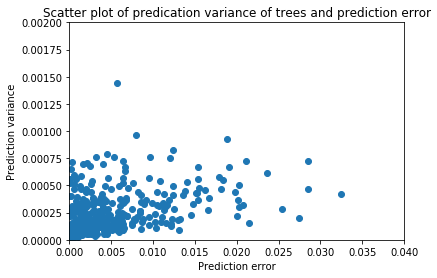

In [80]:
plt.ylim(0, 0.002)
plt.xlim(0, 0.04)
x = [abs(number) for number in trials_.e_mean] 
#     print(x)
plt.scatter(x, trials_.p_var)
plt.title('Scatter plot of predication variance of trees and prediction error')
plt.xlabel('Prediction error')
plt.ylabel('Prediction variance')
plt.show()


In [134]:
# AL_error = trials_.y_pred_AL - trials_.y_test_AL
# AL_mean = AL_error.mean(axis=0).abs()

# SUP_error = trials_.y_pred_SUP - trials_.y_test_SUP
# SUP_mean = SUP_error.mean(axis=0).abs()



title = "Mean Squared Error vs Number of samples"
xlabel = "Number of iterations"
ylabel = "MSE"
list_ = [i for i in range(params["total_experiments"]-params["init_samples"])]

plot_bokeh(df_AL.mean(axis=1).rolling(100).sum().values, df_SUP.mean(axis=1).rolling(100).sum().values, list_, title, xlabel, ylabel)


Loading BokehJS ...

In [136]:
output_notebook()
# file_name = "../temp/" + title + ".html"
# output_file(file_name) #Uncom`ment it to save the plot in html file
p=figure(plot_width=800, plot_height=400,  x_axis_label = "time slot of day", y_axis_label = "energy consumption",)
p.line(trials_.y_pred_AL.index, trials_.y_test_AL.loc[:,"iter1_exp50":"iter1_exp85"].mean(axis=1).values, line_width=1, color='blue')
p.line(trials_.y_pred_AL.index, trials_.y_pred_AL.loc[:,"iter1_exp50":"iter1_exp85"].mean(axis=1).values, line_width=1, color='orange')

show(p)


Loading BokehJS ...

In [126]:
file_name = "../results/SUP_errors" + str(today) + ".csv"
df_SUP.to_csv(file_name, sep='\t')

file_name = "../results/AL_errors" + str(today) + ".csv"
df_AL.to_csv(file_name, sep='\t')
